# RAPSD analysis of AI generated faces

In [ ]:
!pip install -q deeplake
!pip install -q pysteps
!pip install -q datasets

In [ ]:
import os
import time
import copy
import itertools
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from scipy.signal import welch
from scipy.interpolate import interp1d
from skimage import io, color
from IPython.display import Audio, display
import tensorflow_datasets as tfds
import librosa
from pysteps.utils import spectral
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from datasets import load_dataset, concatenate_datasets
from google.colab import drive
drive.mount('/content/drive')
import kagglehub
# Configure matplotlib for animations
rc('animation', html='jshtml')

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1


In [ ]:

print("Path to dataset files:", path)

# List the files and directories in the dataset
for root, dirs, files in os.walk(path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print()  # For better readability between results

Path to dataset files: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1
Root: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1
Directories: ['Dataset']
Files: []

Root: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset
Directories: ['Train', 'Validation', 'Test']
Files: []

Root: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Train
Directories: ['Real', 'Fake']
Files: []

Root: /root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Train/Real
Directories: []
Files: ['real_47812.jpg', 'real_10839.jpg', 'real_25097.jpg', 'real_36122.jpg', 'real_63977.jpg', 'real_44525.jpg', 'real_21483.jpg', 'real_41114.jpg', 'real_15365.jpg', 'real_62845.jpg', 'real_46304.jpg', 'real_44288.jpg', 'real_62283.jpg', 'real_50709.jpg', 'real_33936.jpg', 'real_44052.jpg', 'real_67798.jpg', 'real_22678.jpg', 'real_12243.jpg', 'real_38360.j

In [ ]:
data_fake = os.path.join(path, "Dataset/Train/Fake")

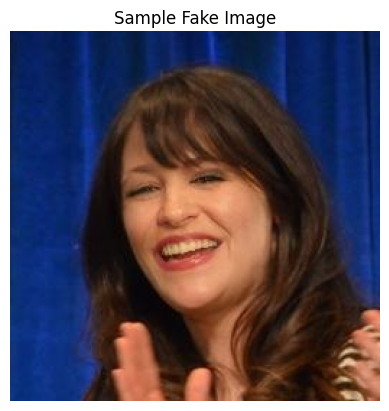

In [ ]:
# List all image files in train/FAKE
img_fake = [os.path.join(data_fake, img) for img in os.listdir(data_fake)]

# Display a sample image
sample_image_path = img_fake[2]  # First image in the folder
img = Image.open(sample_image_path)

plt.imshow(img)
plt.title("Sample Fake Image")
plt.axis("off")
plt.show()

In [ ]:
def resize_and_crop(image, smallest_side):
    height, width, num_channels = image.shape

    # Resize.
    if height <= width:
        new_height = smallest_side
        new_width = int(width * (new_height / height))
    else:
        new_width = smallest_side
        new_height = int(height * (new_width / width))

    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Centre crop.
    offset_h = (new_height - smallest_side) // 2
    offset_w = (new_width - smallest_side) // 2

    return image[offset_h:offset_h + smallest_side, offset_w:offset_w + smallest_side, :]

In [ ]:
image_size = 256
num_examples = 5000
images_fake = []
for filepath in itertools.islice(img_fake, num_examples):
    if os.path.isfile(filepath):  # Ensure the file exists
        # Open the image
        img = Image.open(filepath).convert("RGB")  # Convert to RGB to handle all formats
        arr = np.array(img)
        arr = resize_and_crop(arr, image_size)  # Apply resize and crop
        images_fake.append(arr)
    else:
        print(f"File not found: {filepath}")

# Convert the list to a NumPy array
images_fake = np.array(images_fake)

In [ ]:
images_fake = (images_fake.astype(np.float32) / 255.0) * 2 - 1  # Scale and shift to [-1, 1].

In [ ]:
def calc_mean_log_rapsd(x):
  spectra = []
  for k in range(num_examples):
    rapsd, frequencies = spectral.rapsd(x[k, ...], fft_method=np.fft, return_freq=True)
    spectra.append(rapsd)

  mean_log_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_rapsd, frequencies

0.11344405610336221


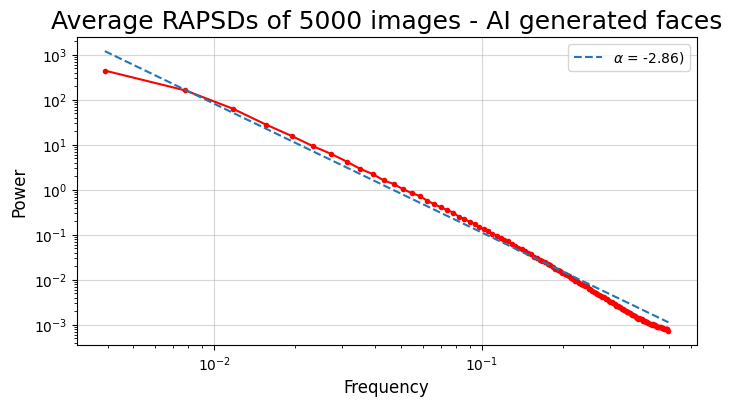

In [ ]:
# Plotting the log RAPSDs
mean_log_rapsd_fake, frequencies_fake = calc_mean_log_rapsd(images_fake[..., 1])

# Getting the alpha exponent of powerlaw
log_frequencies_fake = np.log(frequencies_fake[1:])
equally_spaced_log_frequencies_fake = np.linspace(log_frequencies_fake[0], log_frequencies_fake[-1], 1000)
interpolated_rapsd_fake = np.interp(equally_spaced_log_frequencies_fake, log_frequencies_fake, mean_log_rapsd_fake[1:])
m_fake, b_fake = np.polyfit(equally_spaced_log_frequencies_fake, interpolated_rapsd_fake, 1)
linear_fit_fake = m_fake * equally_spaced_log_frequencies_fake + b_fake

# Residuals
mse_fake = np.mean((linear_fit_fake - interpolated_rapsd_fake)**2)
print(mse_fake)
residuals_mse_fake = np.sqrt(mse_fake)

# Plotting

plt.figure(figsize=(8, 4))
plt.title("Average RAPSDs of 5000 images - AI generated faces", fontsize = 18)
plt.plot(frequencies_fake[1:], np.exp(mean_log_rapsd_fake)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies_fake), np.exp(linear_fit_fake), label=f'$\\alpha$ = {m_fake:.2f})', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Power', fontsize = 12);


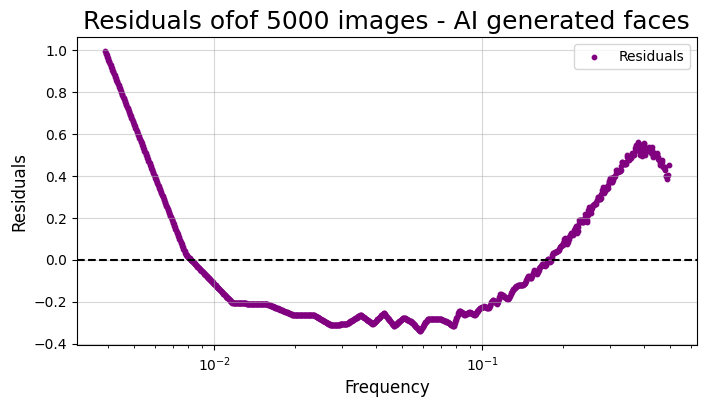

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 4))
residuals_fake = linear_fit_fake - interpolated_rapsd_fake
plt.scatter(np.exp(equally_spaced_log_frequencies_fake), residuals_fake, color='purple', label="Residuals", s=10)
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Residuals', fontsize = 12)
plt.title("Residuals ofof 5000 images - AI generated faces", fontsize = 18)

plt.grid(alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
print("Max residuals of fake faces:", max(residuals_fake))
print("Min residuals of fake faces:", min(residuals_fake))

Max residuals of fake faces: 0.9947328363700025
Min residuals of fake faces: -0.34040846313394413


# For real images of faces

In [ ]:
data_real = os.path.join(path, "Dataset/Train/Real")

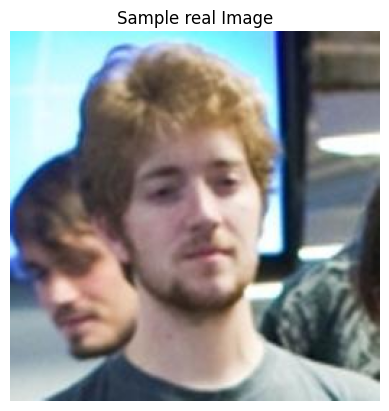

In [ ]:
# List all image files in train/FAKE
img_real = [os.path.join(data_real, img) for img in os.listdir(data_real)]

# Display a sample image
sample_image_path = img_real[0]  # First image in the folder
img = Image.open(sample_image_path)

plt.imshow(img)
plt.title("Sample real Image")
plt.axis("off")
plt.show()

In [ ]:
image_size = 256
num_examples = 5000
images_real = []
for filepath in itertools.islice(img_real, num_examples):
    if os.path.isfile(filepath):  # Ensure the file exists
        # Open the image
        img = Image.open(filepath).convert("RGB")  # Convert to RGB to handle all formats
        arr = np.array(img)
        arr = resize_and_crop(arr, image_size)  # Apply resize and crop
        images_real.append(arr)
    else:
        print(f"File not found: {filepath}")

# Convert the list to a NumPy array
images_real = np.array(images_real)

In [ ]:
images_real = (images_real.astype(np.float32) / 255.0) * 2 - 1  # Scale and shift to [-1, 1].

0.1594134453427571


Text(0, 0.5, 'Power')

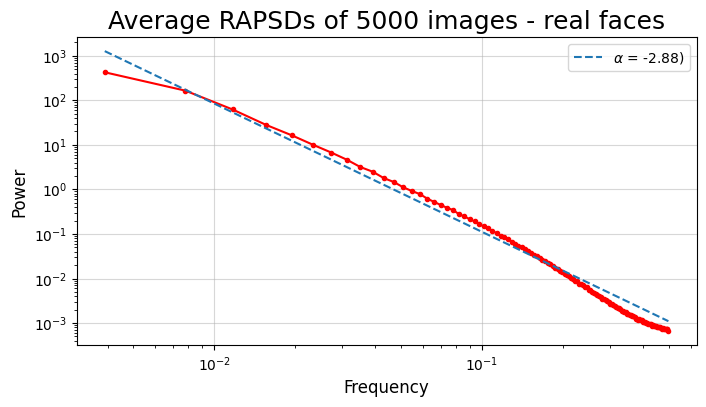

In [ ]:
# Plotting the log RAPSDs
mean_log_rapsd_real, frequencies_real = calc_mean_log_rapsd(images_real[..., 1])

# Getting the alpha exponent of powerlaw
log_frequencies_real = np.log(frequencies_real[1:])
equally_spaced_log_frequencies_real = np.linspace(log_frequencies_real[0], log_frequencies_real[-1], 1000)
interpolated_rapsd_real = np.interp(equally_spaced_log_frequencies_real, log_frequencies_real, mean_log_rapsd_real[1:])

m_real, b_real = np.polyfit(equally_spaced_log_frequencies_real, interpolated_rapsd_real, 1)
linear_fit_real = m_real * equally_spaced_log_frequencies_real + b_real

# Residuals
mse_real = np.mean((linear_fit_real - interpolated_rapsd_real)**2)
print(mse_real)
residuals_mse_real = np.sqrt(mse_real)

# Plotting

plt.figure(figsize=(8, 4))
plt.title("Average RAPSDs of 5000 images - real faces", fontsize = 18)
plt.plot(frequencies_real[1:], np.exp(mean_log_rapsd_real)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies_real), np.exp(linear_fit_real), label=f'$\\alpha$ = {m_real:.2f})', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Power', fontsize = 12)


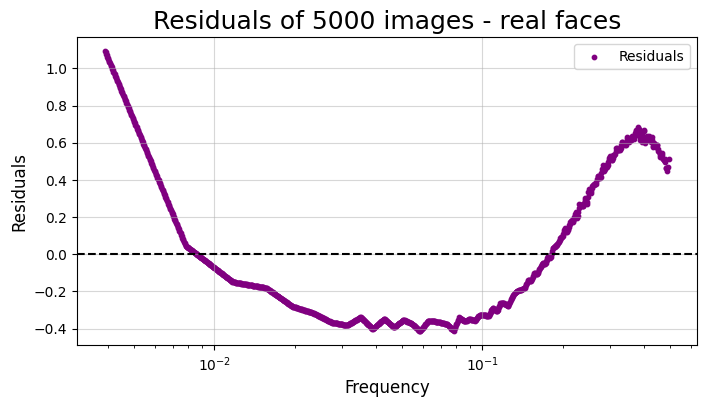

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 4))
residuals_real = linear_fit_real - interpolated_rapsd_real
plt.scatter(np.exp(equally_spaced_log_frequencies_real), residuals_real, color='purple', label="Residuals", s=10)
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Residuals', fontsize = 12)
plt.title("Residuals of 5000 images - real faces", fontsize = 18)

plt.grid(alpha = 0.5)
plt.legend()
plt.show()

-----------------